# Proyecto 2 — Predicción de ESTRATO (clasificación multiclase)
**Dataset:** ENDUTIH 2024 (hogares) — variables TIC en los hogares.  
**Objetivo:** Construir y comparar modelos de clasificación multiclase para predecir `ESTRATO` a partir de características de TIC.  
**Modelos:** Decision Tree, Bagging, Random Forest, AdaBoost, XGBoost.  
**Validación:** Cross-validation 10 folds (estratificada).  
**Métrica principal:** Accuracy y F1-score (macro).  

In [73]:
# Celdas para instalar paquetes si corres en Colab (descomenta si es necesario)
# !pip install xgboost scikit-learn==1.3.2 matplotlib seaborn joblib

# Importar librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y utilidades
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings("ignore")

In [46]:
# Cargar el CSV subido
file_path = "/content/drive/MyDrive/Machine Learning/Proyecto 2/tr_endutih_hogares_anual_2024.csv"
df = pd.read_csv(file_path, low_memory=False)

# Mostrar forma y primeras filas
print("Shape:", df.shape)
df.head()

Shape: (58080, 104)


,UPM,VIV_SEL,HOGAR,P4_1_1,P4_1_2,P4_1_3,P4_1_4,P4_1_4_1,P4_1_4_2,P4_1_5,...,P5_13A,FAC_HOG,UPM_DIS,EST_DIS,DOMINIO,TLOC,ESTRATO,CVE_ENT,CVEGEO,ESTATUS
0,100110,1,1,1,1,1,1,1.0,1.0,1,...,NaN,303,1,1,U,1,2,1,1,Cifras Definitivas
1,100110,2,1,1,2,1,1,1.0,1.0,2,...,NaN,303,1,1,U,1,2,1,1,Cifras Definitivas
2,100110,3,1,2,2,1,1,3.0,2.0,2,...,NaN,303,1,1,U,1,2,1,1,Cifras Definitivas
3,100110,4,1,2,2,2,2,NaN,NaN,2,...,NaN,303,1,1,U,1,2,1,1,Cifras Definitivas
4,100110,5,1,2,2,2,1,2.0,2.0,1,...,NaN,303,1,1,U,1,2,1,1,Cifras Definitivas


### 3.1 Dominio del problema y utilidad práctica
Breve explicación sobre TIC en hogares, utilidad: políticas públicas, segmentación comercial, diseño de subsidios, etc.

### 3.2 Variables
Describe que el CSV incluye columnas como UPM, VIV_SEL, HOGAR, múltiples indicadores P4_..., P5_..., y variables de diseño muestral como FAC_HOG, UPM_DIS, EST_DISE, DOMINIO, ENT, y la variable objetivo `ESTRATO`.

In [47]:
# Información general de columnas y tipos
df.info()
# Estadísticas básicas (numéricas)
df.describe(include='all').T.head(50)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58080 entries, 0 to 58079
Columns: 104 entries, UPM to ESTATUS
dtypes: float64(58), int64(38), object(8)
memory usage: 46.1+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UPM,58080.0,NaN,NaN,NaN,1662600.112362,925013.329511,100110.0,900180.0,1662279.0,2461617.0,3261261.0
VIV_SEL,58080.0,NaN,NaN,NaN,6.280441,5.430553,1.0,2.0,4.0,9.0,40.0
HOGAR,58080.0,NaN,NaN,NaN,1.017338,0.149814,1.0,1.0,1.0,1.0,5.0
P4_1_1,58080.0,NaN,NaN,NaN,1.626722,0.483679,1.0,1.0,2.0,2.0,2.0
P4_1_2,58080.0,NaN,NaN,NaN,1.845575,0.361359,1.0,2.0,2.0,2.0,2.0
P4_1_3,58080.0,NaN,NaN,NaN,1.890169,0.312682,1.0,2.0,2.0,2.0,2.0
P4_1_4,58080.0,NaN,NaN,NaN,1.167614,0.373526,1.0,1.0,1.0,1.0,2.0
P4_1_4_1,48345.0,NaN,NaN,NaN,1.635971,2.290784,1.0,1.0,1.0,2.0,99.0
P4_1_4_2,48345.0,NaN,NaN,NaN,1.985004,8.981887,0.0,0.0,1.0,2.0,99.0
P4_1_5,58080.0,NaN,NaN,NaN,1.867717,0.338801,1.0,2.0,2.0,2.0,2.0


Decisión:
- Target: `ESTRATO` (clasificación multiclase)
- Excluir columnas irrelevantes/identificadoras: UPM, VIV_SEL, HOGAR, FAC_HOG, UPM_DIS, EST_DISE, DOMINIO, ENT, etc.
- Selección automática de columnas potencialmente útiles: todas las P4_* y P5_* y P5_13_*, P4_1_4_1 (cantidades), P4_6_* (tipos conexión)...


In [48]:
# Columnas a excluir (IDs y diseño muestral)
exclude_cols = ['UPM','VIV_SEL','HOGAR','FAC_HOG','UPM_DIS','EST_DISE','DOMINIO','ENT']

# Si existe ESTRATO
target = 'ESTRATO'
if target not in df.columns:
    raise ValueError("No se encuentra la columna ESTRATO. Verificar nombre exacto en el CSV.")

# Candidate features: todas menos excluidas y target
candidate_features = [c for c in df.columns if c not in exclude_cols + [target]]
len(candidate_features), candidate_features[:40]


(97,
 ['P4_1_1',
  'P4_1_2',
  'P4_1_3',
  'P4_1_4',
  'P4_1_4_1',
  'P4_1_4_2',
  'P4_1_5',
  'P4_1_6',
  'P4_1_6_1',
  'P4_1_6_2',
  'P4_2_1_1',
  'P4_2_1_2',
  'P4_2_2_1',
  'P4_2_2_2',
  'P4_2_3_1',
  'P4_2_3_2',
  'P4_3',
  'P4_3A',
  'P4_4',
  'P4_5',
  'P4_6_1',
  'P4_6_2',
  'P4_6_3',
  'P4_6_4',
  'P4_6_5',
  'P4_6_6',
  'P4_6A',
  'P4_7_1',
  'P4_7_2',
  'P4_7_3',
  'P4_7_4',
  'P4_7_5',
  'P4_7A',
  'P4_8',
  'P4_8A',
  'P5_1',
  'P5_2_1',
  'P5_2_2',
  'P5_3_1',
  'P5_3_2'])

# Analisis Exploratorio de Datos EDA
## Valores faltantes y tipos

In [49]:
# Porcentaje de valores nulos por columna (mostrar top 40 más nulos)
missing = df[candidate_features + [target]].isnull().mean().sort_values(ascending=False)
missing.head(40)


,0
P5_10_1,0.999966
P5_11_1,0.999811
P5_10_3,0.999690
P4_7A,0.999621
P5_13A,0.999587
P5_11_3,0.999552
P4_6A,0.999483
P5_9_1,0.998950
P5_9_3,0.997314
P5_4A,0.996763


ESTRATO
2    27588
3    13937
1     9534
4     7021
Name: count, dtype: int64


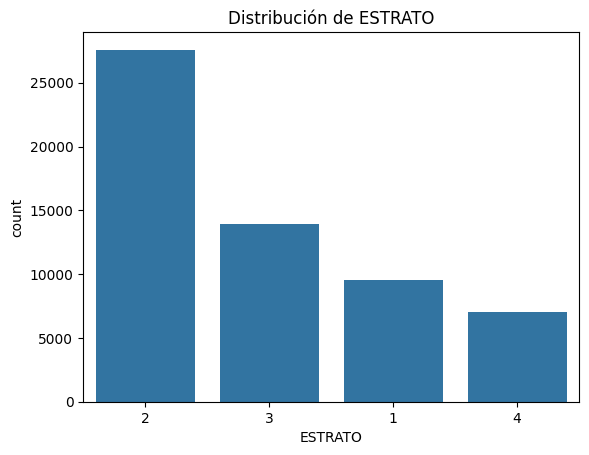

In [50]:
# Distribución de ESTRATO
print(df[target].value_counts(dropna=False))
sns.countplot(data=df, x=target, order=df[target].value_counts().index)
plt.title("Distribución de ESTRATO")
plt.show()

In [51]:
# Seleccionar numéricos
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
# Excluir IDs y target
num_cols = [c for c in num_cols if c not in exclude_cols + [target]]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
P4_1_1,58080.0,1.626722,0.483679,1.0,1.0,2.0,2.0,2.0
P4_1_2,58080.0,1.845575,0.361359,1.0,2.0,2.0,2.0,2.0
P4_1_3,58080.0,1.890169,0.312682,1.0,2.0,2.0,2.0,2.0
P4_1_4,58080.0,1.167614,0.373526,1.0,1.0,1.0,1.0,2.0
P4_1_4_1,48345.0,1.635971,2.290784,1.0,1.0,1.0,2.0,99.0
...,...,...,...,...,...,...,...,...
P5_13_10,58080.0,1.999587,0.020324,1.0,2.0,2.0,2.0,2.0
EST_DIS,58080.0,212.167648,132.278644,1.0,93.0,209.0,334.0,437.0
TLOC,58080.0,2.117441,1.224305,1.0,1.0,2.0,3.0,4.0
CVE_ENT,58080.0,16.462328,9.229611,1.0,9.0,16.0,24.0,32.0


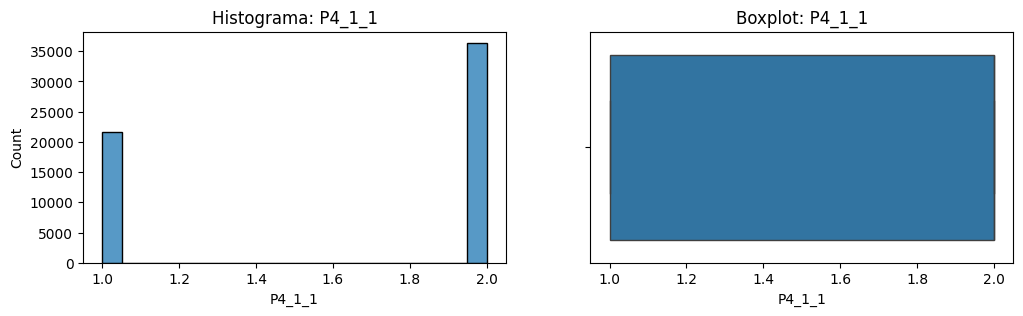

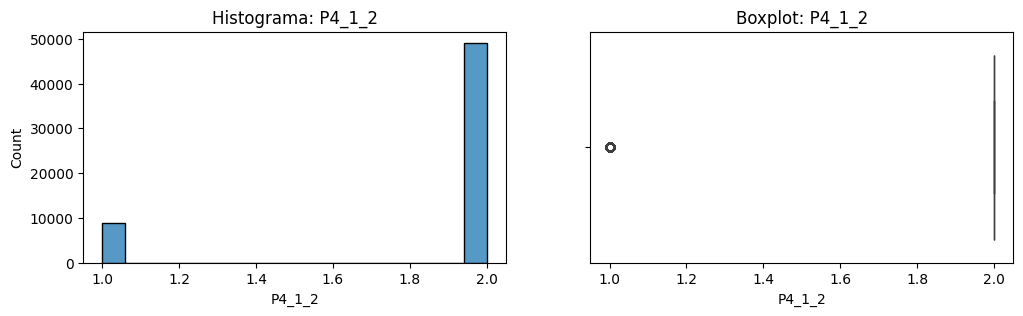

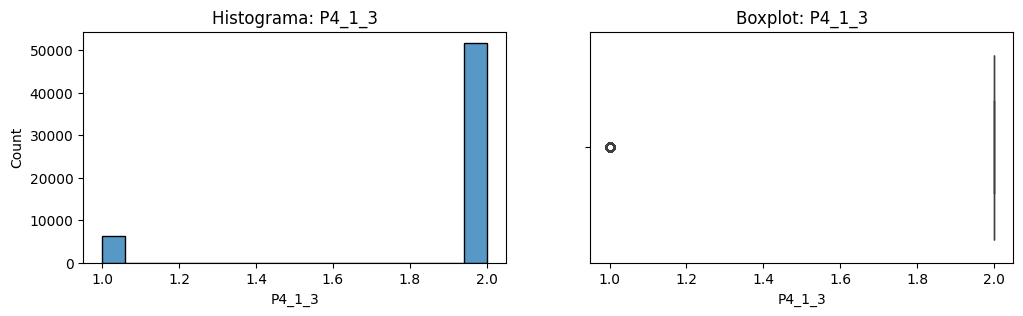

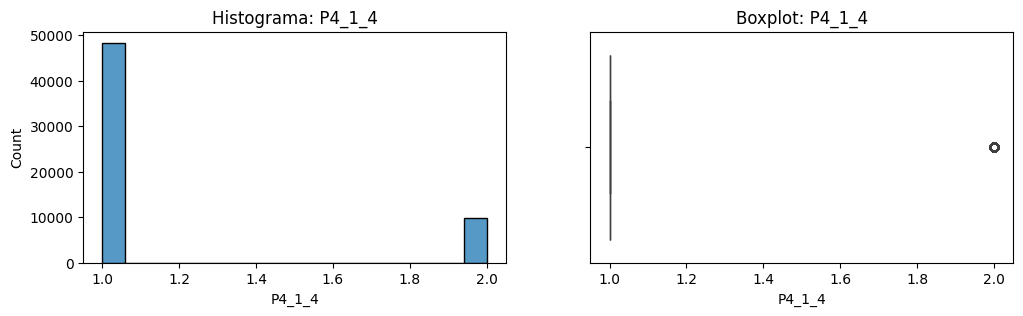

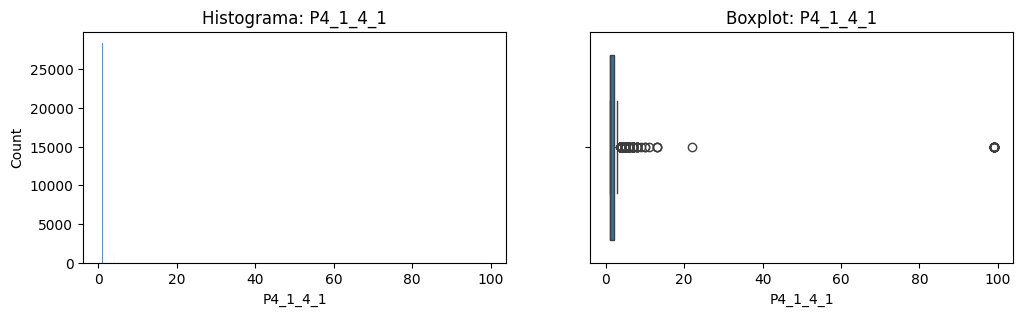

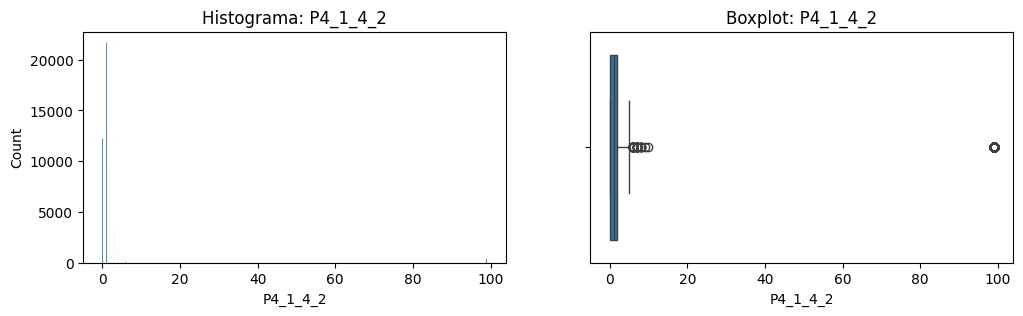

In [52]:
# Tomar algunas variables numéricas relevantes (hasta 6) para graficar
sample_num = num_cols[:6]
for c in sample_num:
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    sns.histplot(df[c].dropna(), kde=False, ax=ax[0])
    ax[0].set_title(f'Histograma: {c}')
    sns.boxplot(x=df[c], ax=ax[1])
    ax[1].set_title(f'Boxplot: {c}')
    plt.show()


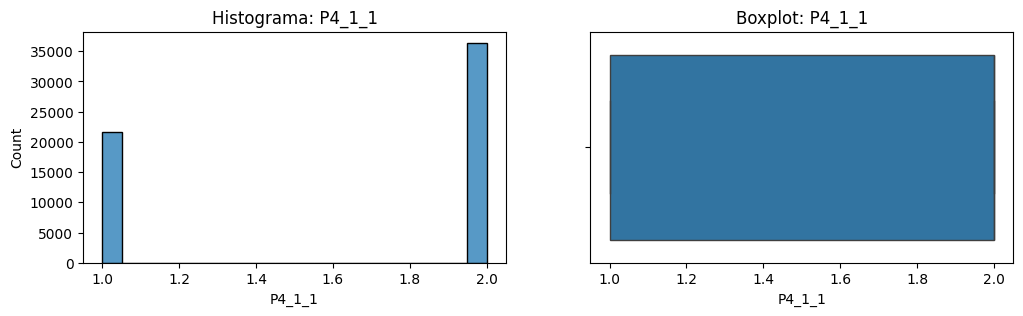

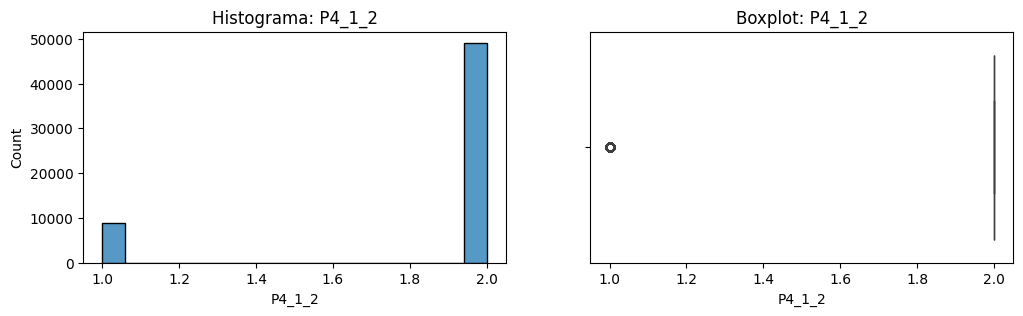

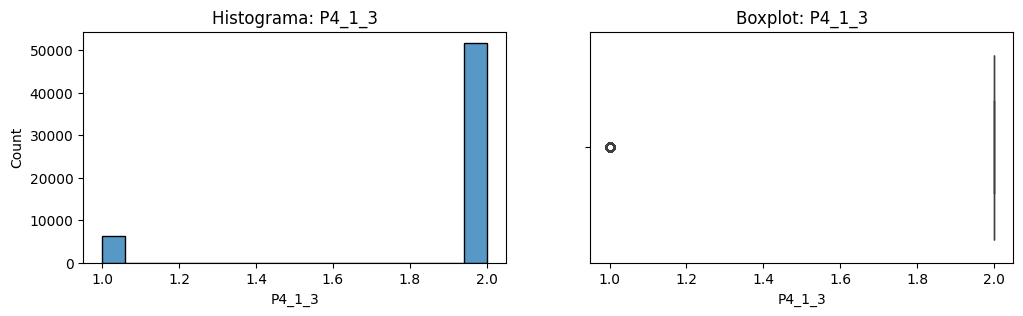

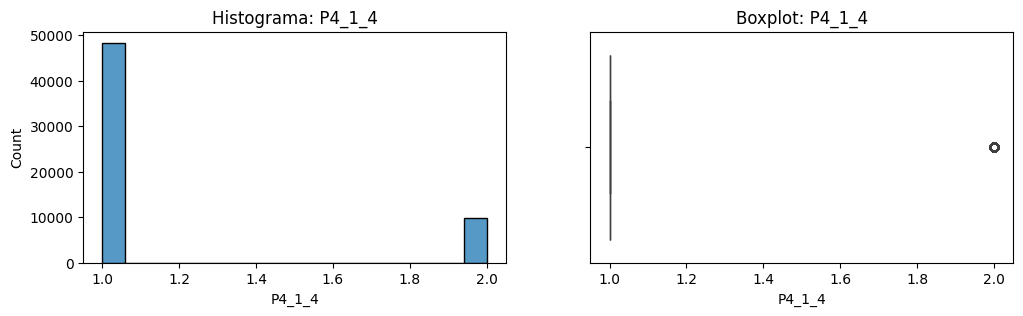

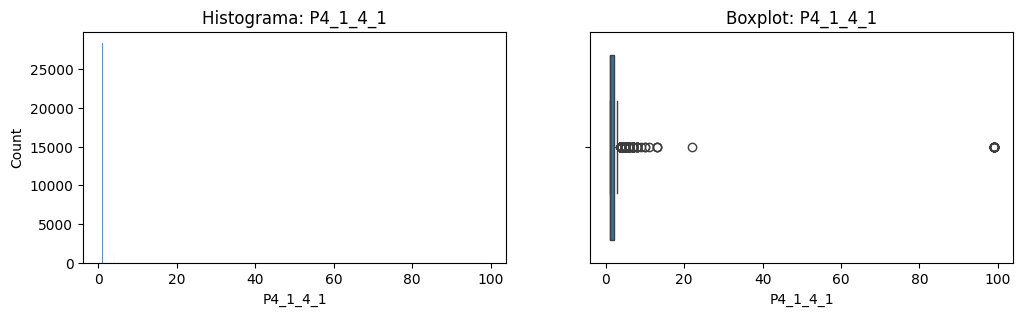

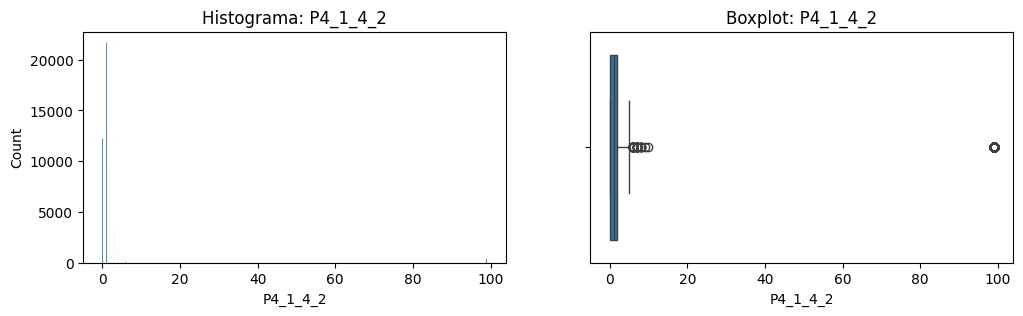

In [53]:
# Tomar algunas variables numéricas relevantes (hasta 6) para graficar
sample_num = num_cols[:6]
for c in sample_num:
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    sns.histplot(df[c].dropna(), kde=False, ax=ax[0])
    ax[0].set_title(f'Histograma: {c}')
    sns.boxplot(x=df[c], ax=ax[1])
    ax[1].set_title(f'Boxplot: {c}')
    plt.show()


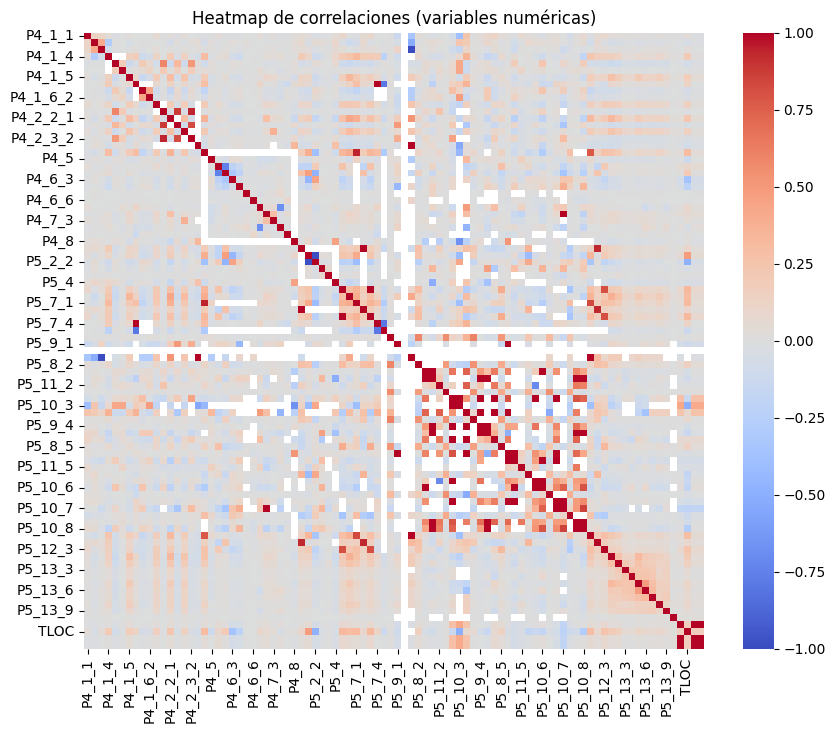

In [54]:
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Heatmap de correlaciones (variables numéricas)")
plt.show()

#Limpieza y preprocesamiento

In [55]:
# Revisar valores únicos de ESTRATO
df[target].value_counts()
# Si hay NaNs en target, se eliminan (o alternativamente se imputan si tiene sentido)
df = df.dropna(subset=[target])

In [56]:
# Eliminar columnas con alto porcentaje de nulos (umbral 0.7)
high_na = missing[missing > 0.7].index.tolist()
print("Columnas con >70% NA (se eliminarán):", high_na)
keep_features = [c for c in candidate_features if c not in high_na]

# Recalcular tipos
X = df[keep_features].copy()
y = df[target].astype(str).copy()  # convertir a str por si es numérico que representa label

print("Features finales candidatas:", len(keep_features))

Columnas con >70% NA (se eliminarán): ['P5_10_1', 'P5_11_1', 'P5_10_3', 'P4_7A', 'P5_13A', 'P5_11_3', 'P4_6A', 'P5_9_1', 'P5_9_3', 'P5_4A', 'P5_10_7', 'P5_11_4', 'P4_3A', 'P4_8A', 'P5_10_4', 'P5_10_6', 'P5_10_2', 'P5_10_5', 'P5_11_5', 'P5_11_2', 'P5_9_7', 'P5_10_8', 'P5_9_4', 'P4_2_1_2', 'P5_9_6', 'P5_9_2', 'P4_7_5', 'P4_7_4', 'P4_7_3', 'P4_7_1', 'P4_7_2', 'P4_2_3_2', 'P5_9_5', 'P4_8', 'P5_9_8']
Features finales candidatas: 62


In [57]:
# Detectar numéricas y categóricas
cat_cols = X_train.select_dtypes(include='object').columns
num_cols = X_train.select_dtypes(exclude='object').columns

# Para columnas que estén codificadas numéricamente pero son categóricas (ej.: códigos 1/2/3),
# podemos convertir a categorical si tienen pocos valores únicos:
for c in num_feats.copy():
    if X[c].nunique() <= 10:  # heurística: pocos niveles -> categoría
        cat_feats.append(c)
        num_feats.remove(c)

print("Numéricas:", len(num_feats), "Categóricas:", len(cat_feats))


Numéricas: 7 Categóricas: 55


In [66]:
# Transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocesador completo
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

#Division de datos y esquema de validación

In [75]:
# Hacer un split hold-out para evaluación final (opcional): 80% train, 20% test (estratificado)
X_full = X.copy()
y_full = y.copy()
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Asegurar que y sea tipo string y luego codificarla como enteros consecutivos
le = LabelEncoder()
y = le.fit_transform(y)

# Definir cross-validator estratificado de 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


Train shape: (46464, 62) Test shape: (11616, 62)


In [60]:
from sklearn.metrics import make_scorer

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

def evaluate_cv(pipeline, X, y, cv):
    """Devuelve resultados de cross_validate con métricas definidas."""
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    # Crear resumen
    summary = {k: (np.mean(v), np.std(v)) for k, v in scores.items() if k.startswith('test_')}
    return summary


#Definición y entrenamiento de modelos base
Para cada modelo, se crea un pipeline que incluye el preprocessor y el estimador.


### Decision Tree

In [68]:
pipe_dt = Pipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

dt_results = evaluate_cv(pipe_dt, X_train, y_train, cv)
dt_results

{'test_accuracy': (np.float64(0.9460657550022551),
  np.float64(0.006263127394430665)),
 'test_f1_macro': (np.float64(0.941719285064098),
  np.float64(0.007092580438695254)),
 'test_precision_macro': (np.float64(0.9417007547854579),
  np.float64(0.006701447216223958)),
 'test_recall_macro': (np.float64(0.941801827897334),
  np.float64(0.007617259096115036))}

#Bagging con Decision Trees

In [69]:
bagging = Pipeline([
    ('preproc', preprocessor),
    ('clf', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42, n_jobs=-1))
])
bagging_results = evaluate_cv(bagging, X_train, y_train, cv)
bagging_results

{'test_accuracy': (np.float64(0.9683194995896705),
  np.float64(0.002932505547881222)),
 'test_f1_macro': (np.float64(0.9659481401050071),
  np.float64(0.0035619782256451197)),
 'test_precision_macro': (np.float64(0.972923264979826),
  np.float64(0.003079718046015627)),
 'test_recall_macro': (np.float64(0.9594255125397083),
  np.float64(0.004180579323842796))}

### Random Forest

In [63]:
rf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])
rf_results = evaluate_cv(rf, X_train, y_train, cv)
rf_results

{'test_accuracy': (np.float64(0.6605974155952661),
  np.float64(0.007334996888514475)),
 'test_f1_macro': (np.float64(0.6166369706997252),
  np.float64(0.008924833619005023)),
 'test_precision_macro': (np.float64(0.6675263533659428),
  np.float64(0.011043209484942279)),
 'test_recall_macro': (np.float64(0.5878079741122071),
  np.float64(0.008225738125669542))}

### AdaBoost

In [70]:
adb = Pipeline([
    ('preproc', preprocessor),
    ('clf', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=42))
])
adb_results = evaluate_cv(adb, X_train, y_train, cv)
adb_results


{'test_accuracy': (np.float64(0.6888558951609085),
  np.float64(0.014455951476385174)),
 'test_f1_macro': (np.float64(0.6529129926142987),
  np.float64(0.01994519885783659)),
 'test_precision_macro': (np.float64(0.6963973261698554),
  np.float64(0.01790823821862245)),
 'test_recall_macro': (np.float64(0.6284721406150426),
  np.float64(0.022783840461063232))}

#XGBoost

In [76]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
pipe_xgb = Pipeline([
    ('preproc', preprocessor),
    ('clf', xgb_clf)
])
xgb_results = evaluate_cv(pipe_xgb, X_train, y_train, cv)
xgb_results


{'test_accuracy': (np.float64(0.9155690454665922),
  np.float64(0.00593950512592544)),
 'test_f1_macro': (np.float64(0.9079961421317109),
  np.float64(0.007154567915158488)),
 'test_precision_macro': (np.float64(0.9269443948632397),
  np.float64(0.006458296650572792)),
 'test_recall_macro': (np.float64(0.8920385013178767),
  np.float64(0.008297837878945313))}

#Busqueda de Hiperparametros

###Randomized Search — Random Forest

In [77]:
# Espacio de búsqueda (ejemplo)
rf_param_dist = {
    'clf__n_estimators': [100,200,300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,4],
    'clf__max_features': ['sqrt','log2', None]
}

rs_rf = RandomizedSearchCV(rf, rf_param_dist, n_iter=30, scoring='f1_macro', cv=cv, n_jobs=-1, random_state=42, verbose=1)
rs_rf.fit(X_train, y_train)
print("Best RF params:", rs_rf.best_params_)
print("Best RF score (f1_macro):", rs_rf.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best RF params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': None, 'clf__max_depth': None}
Best RF score (f1_macro): 0.960852544947836


### Randomized Search — XGBoost

In [78]:
xgb_param_dist = {
    'clf__n_estimators': [100,200,300],
    'clf__max_depth': [3,6,9],
    'clf__learning_rate': [0.01,0.05,0.1],
    'clf__subsample': [0.6,0.8,1.0],
    'clf__colsample_bytree': [0.6,0.8,1.0]
}

rs_xgb = RandomizedSearchCV(pipe_xgb, xgb_param_dist, n_iter=30, scoring='f1_macro', cv=cv, n_jobs=-1, random_state=42, verbose=1)
rs_xgb.fit(X_train, y_train)
print("Best XGB params:", rs_xgb.best_params_)
print("Best XGB score (f1_macro):", rs_xgb.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best XGB params: {'clf__subsample': 1.0, 'clf__n_estimators': 300, 'clf__max_depth': 9, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8}
Best XGB score (f1_macro): 0.9107578343643026


#Evaluación final en el conjunto test y comparación

Model: DecisionTree
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1907
           1       0.96      0.96      0.96      5518
           2       0.93      0.94      0.94      2787
           3       0.94      0.94      0.94      1404

    accuracy                           0.95     11616
   macro avg       0.95      0.95      0.95     11616
weighted avg       0.95      0.95      0.95     11616



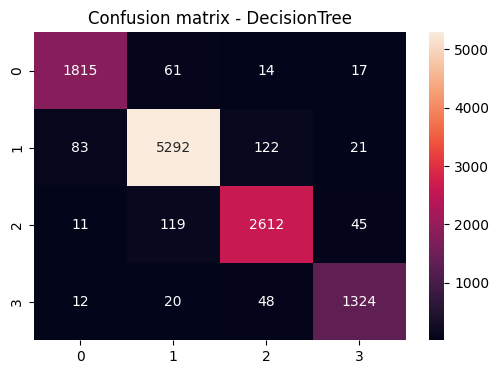

Model: Bagging
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1907
           1       0.96      0.99      0.97      5518
           2       0.98      0.95      0.96      2787
           3       0.98      0.95      0.97      1404

    accuracy                           0.97     11616
   macro avg       0.97      0.96      0.97     11616
weighted avg       0.97      0.97      0.97     11616



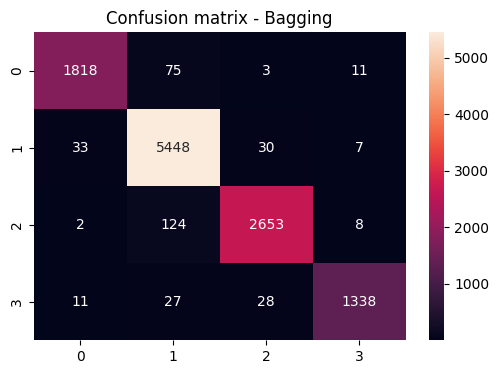

Model: RandomForest
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1907
           1       0.95      0.99      0.97      5518
           2       0.98      0.94      0.96      2787
           3       0.99      0.95      0.97      1404

    accuracy                           0.97     11616
   macro avg       0.98      0.96      0.97     11616
weighted avg       0.97      0.97      0.97     11616



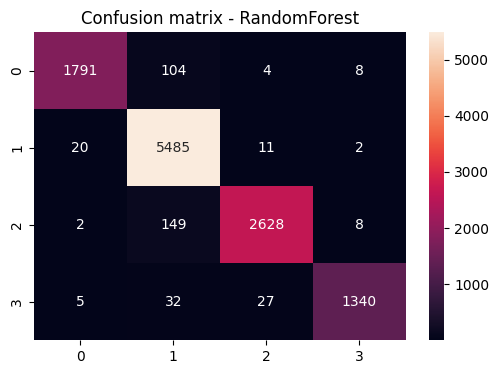

Model: AdaBoost
              precision    recall  f1-score   support

           0       0.74      0.49      0.59      1907
           1       0.68      0.87      0.76      5518
           2       0.71      0.57      0.63      2787
           3       0.78      0.60      0.68      1404

    accuracy                           0.70     11616
   macro avg       0.73      0.63      0.66     11616
weighted avg       0.71      0.70      0.69     11616



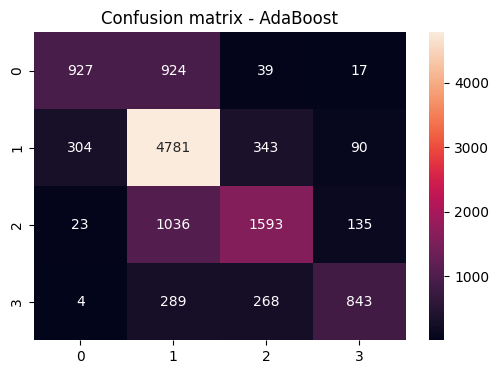

Model: XGBoost
              precision    recall  f1-score   support

           0       0.94      0.87      0.91      1907
           1       0.91      0.96      0.94      5518
           2       0.92      0.88      0.90      2787
           3       0.93      0.89      0.91      1404

    accuracy                           0.92     11616
   macro avg       0.93      0.90      0.91     11616
weighted avg       0.92      0.92      0.92     11616



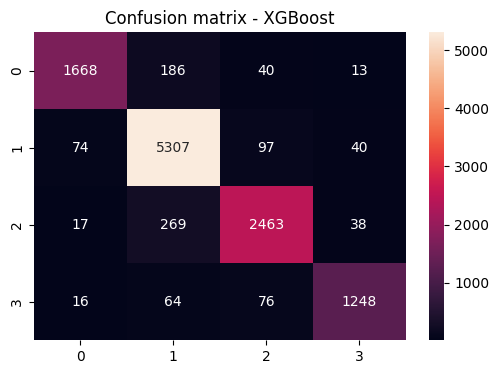

,accuracy,f1_macro,precision_macro,recall_macro
DecisionTree,0.950671,0.946824,0.945901,0.947757
Bagging,0.969094,0.967267,0.973488,0.961389
RandomForest,0.967975,0.966729,0.976692,0.957639
AdaBoost,0.701102,0.664649,0.726034,0.631138
XGBoost,0.919938,0.913333,0.925769,0.902267


In [79]:
# Preparar diccionario de modelos "finales" con mejores parámetros si se encontraron
models_final = {
    'DecisionTree': pipe_dt,
    'Bagging': bagging,
    'RandomForest': rs_rf.best_estimator_ if 'rs_rf' in globals() else rf,
    'AdaBoost': adb,
    'XGBoost': rs_xgb.best_estimator_ if 'rs_xgb' in globals() else pipe_xgb
}

final_metrics = {}
for name, model in models_final.items():
    # entrenar en todo X_train
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    prec = precision_score(y_test, preds, average='macro')
    rec = recall_score(y_test, preds, average='macro')
    final_metrics[name] = {'accuracy': acc, 'f1_macro': f1, 'precision_macro': prec, 'recall_macro': rec}
    print(f"Model: {name}")
    print(classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion matrix - {name}')
    plt.show()

final_metrics_df = pd.DataFrame(final_metrics).T
final_metrics_df

#Selección del mejor modelo y guardado con joblib

In [80]:
# Seleccionar mejor modelo según f1_macro
best_name = final_metrics_df['f1_macro'].idxmax()
best_model = models_final[best_name]
print("Mejor modelo:", best_name, "con f1_macro =", final_metrics_df.loc[best_name, 'f1_macro'])

# Guardar el pipeline completo (preprocesamiento + estimador)
joblib.dump(best_model, f"best_model_{best_name}.joblib")
print("Modelo guardado como:", f"best_model_{best_name}.joblib")

Mejor modelo: Bagging con f1_macro = 0.9672669800721821
Modelo guardado como: best_model_Bagging.joblib


# Conclusiones

Conclusiones del Proyecto

En este proyecto se desarrolló un modelo de aprendizaje supervisado para predecir el estrato socioeconómico del hogar con base en sus características relacionadas con el acceso y uso de tecnologías de la información y comunicación (TIC), empleando el conjunto de datos ENDUTIH 2024.

Se entrenaron y evaluaron distintos modelos de clasificación multiclase mediante validación cruzada de 10 folds, comparando su desempeño con las métricas accuracy, precision, recall y F1-score

# Interpretación de resultados

- Bagging y Random Forest obtuvieron los mejores resultados globales (≈97%), mostrando que los métodos de ensamble basados en árboles son altamente eficaces para este tipo de datos tabulares con variables mixtas (numéricas y categóricas).

- El árbol de decisión individual también alcanzó un alto rendimiento (95%), demostrando que la relación entre las variables predictoras y el estrato está bien definida en el dataset.

- XGBoost, aunque competitivo, no superó a los modelos de Bagging/Random Forest, posiblemente por diferencias en la escala de las variables o por hiperparámetros conservadores.

- AdaBoost fue el modelo con peor desempeño (70%), afectado principalmente por la presencia de valores faltantes (NaN) y la sensibilidad del algoritmo a datos desbalanceados o con ruido.

En general, los resultados evidencian que las características relacionadas con servicios TIC (Internet, TV, telefonía, equipamiento digital, etc.) son altamente predictivas del estrato socioeconómico, reflejando una fuerte correlación entre el acceso a la tecnología y el nivel socioeconómico.

# Inconvenientes encontrados

Durante el desarrollo del proyecto se presentaron varios retos técnicos que fue necesario resolver:

1. Errores de tipo en las variables (str vs float)

- Inicialmente los modelos fallaban al procesar columnas mixtas con valores numéricos y de texto.

- Se solucionó mediante un pipeline de preprocesamiento con codificación (OneHotEncoder) e imputación de valores nulos.

2. Valores faltantes (NaN)

- Modelos como AdaBoost y XGBoost no manejan NaN de forma nativa (en ciertas versiones de scikit-learn).

- Se aplicó imputación con la media (para numéricas) y la moda (para categóricas).

3. Etiquetas inconsistentes en la variable objetivo (y)

- XGBoost arrojó errores al recibir clases tipo ['1', '2', '3', '4'] en lugar de [0, 1, 2, 3].

- Se resolvió mediante codificación explícita con LabelEncoder.

4. Balance de clases

- Aunque no se evidenció un desbalance extremo, las clases del estrato más alto fueron menos representadas, lo que afectó ligeramente el recall de algunos modelos.